In [3]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from joblib import dump, load
import shap
from sklearn.feature_selection import SelectFromModel
from category_encoders import CountEncoder
from scipy.stats import chi2_contingency
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from math import log2, ceil
from sklearn.feature_selection import SelectFpr, chi2
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("deep")
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

In [46]:
import os
import requests

telegram_api_token = os.getenv("telegram_api_token")
telegram_chat_id = os.getenv("telegram_chat_id")


def notify(text="Execution completed."):
    if telegram_api_token and telegram_chat_id:
        requests.post(
            "https://api.telegram.org/"
            + "bot{}/sendMessage".format(telegram_api_token),
            params=dict(chat_id=telegram_chat_id, text=text),
        )
    else:
        pass


def get_results(gs, features_of_interest=None, round=2):
    results = {
        key: gs.cv_results_[key]
        for key in [
            "mean_fit_time",
            "std_fit_time",
            "mean_train_score",
            "std_train_score",
            "mean_test_score",
            "std_test_score",
            "params",
        ]
    }
    results_df = pd.DataFrame(
        {
            "model": [type(params["model"]).__name__ for params in results["params"]],
            "preprocessing": [
                getattr(params["preprocessing"], "name") for params in results["params"]
            ],
            **results,
        }
    )
    results_df = results_df.round(round)

    if features_of_interest:
        for key, col_name in features_of_interest.items():
            results_df[col_name] = results_df["params"].apply(lambda x: x.get(key))
        results_df = results_df.drop("params", axis=1)

    return results_df

In [6]:
train = pd.read_csv("./resources/train_data.csv", low_memory=False)

test = pd.read_csv("./resources/test_data.csv")

In [7]:
# Drop duplicates
train = train.drop_duplicates()

# Define Claim Identifier as the index
train.set_index("Claim Identifier", inplace=True)
test.set_index("Claim Identifier", inplace=True)

# Drop rows that have missing values in the target
train = train.dropna(subset=["Claim Injury Type"])

# Drop cols that are not on test dataset
train = train.drop(columns=["Agreement Reached", "WCB Decision"])

In [8]:
cause_injury = {
    "I. Burn or Scald - Heat or Cold Exposures - Contact With": [
        "1",
        "2",
        "3",
        "4",
        "5",
        "6",
        "7",
        "8",
        "9",
        "11",
        "14",
        "84",
    ],
    "II. Caught In, Under or Between": ["10", "12", "13", "20"],
    "III. Cut, Puncture, Scrape Injured By": ["15", "16", "17", "18", "19"],
    "IV. Fall, Slip or Trip Injury": [
        "25",
        "26",
        "27",
        "28",
        "29",
        "30",
        "31",
        "32",
        "33",
    ],
    "V. Motor Vehicle": ["40", "41", "45", "46", "47", "48", "50"],
    "VI. Strain or Injury By": [
        "52",
        "53",
        "54",
        "55",
        "56",
        "57",
        "58",
        "59",
        "60",
        "61",
        "97",
    ],
    "VII. Striking Against or Stepping On": [
        "65",
        "66",
        "67",
        "68",
        "69",
        "70",
    ],
    "VIII. Struck or Injured By": [
        "74",
        "75",
        "76",
        "77",
        "78",
        "79",
        "80",
        "81",
        "85",
        "86",
    ],
    "IX. Rubbed or Abraded By": ["94", "95"],
    "X. Miscellaneous Causes": [
        "82",
        "83",
        "87",
        "88",
        "89",
        "90",
        "91",
        "93",
        "96",
        "98",
        "99",
    ],
}

nature_injury = {
    "specific_injury": [
        "1",
        "2",
        "3",
        "4",
        "7",
        "10",
        "13",
        "16",
        "19",
        "22",
        "25",
        "28",
        "30",
        "31",
        "32",
        "34",
        "36",
        "37",
        "38",
        "40",
        "41",
        "42",
        "43",
        "46",
        "47",
        "49",
        "52",
        "53",
        "54",
        "55",
        "58",
        "59",
    ],
    "occupational_disease": [
        "60",
        "61",
        "62",
        "63",
        "64",
        "65",
        "66",
        "67",
        "68",
        "69",
        "70",
        "71",
        "72",
        "73",
        "74",
        "75",
        "76",
        "77",
        "78",
        "79",
        "80",
        "83",
    ],
    "multiple_injuries": ["90", "91"],
}
body_part = {
    "head": [
        "10",
        "11",
        "12",
        "13",
        "13A",
        "13B",
        "13C",
        "14",
        "14A",
        "14B",
        "14C",
        "15",
        "16",
        "17",
        "18",
        "19",
    ],
    "neck": ["20", "21", "22", "23", "24", "25", "26"],
    "upper_extremities": [
        "30",
        "31",
        "32",
        "33",
        "34",
        "35",
        "36",
        "36A",
        "36B",
        "36C",
        "36D",
        "36E",
        "36F",
        "36G",
        "36H",
        "36I",
        "36J",
        "36K",
        "36L",
        "36M",
        "36N",
        "36O",
        "36P",
        "37",
        "37A",
        "37B",
        "37C",
        "38",
        "39",
    ],
    "trunk": [
        "40",
        "41",
        "42",
        "43",
        "44",
        "45",
        "46",
        "47",
        "48",
        "49",
        "60",
        "61",
        "62",
        "63",
    ],
    "lower_extremities": [
        "50",
        "51",
        "52",
        "53",
        "54",
        "55",
        "56",
        "57",
        "57A",
        "57B",
        "57C",
        "57D",
        "57E",
        "57F",
        "57G",
        "58",
        "58A",
        "58B",
        "58C",
    ],
    "multiple_body_parts": ["64", "65", "66", "90", "91", "99"],
}

In [9]:
missing_dict = {
    col: round(train[col].isna().sum() * 100 / len(train), 2) for col in train.columns
}

missing_df = pd.DataFrame(
    list(missing_dict.items()), columns=["Column", "Missing Percentage"]
)

missing_df[missing_df["Missing Percentage"] > 50].sort_values(
    by="Missing Percentage", ascending=False
)

,Column,Missing Percentage
21,OIICS Nature of Injury Description,100.00
17,IME-4 Count,76.86
15,First Hearing Date,73.73
8,C-3 Date,67.38


In [10]:
# Independent variables
X = train.drop(["Claim Injury Type"], axis=1)

# Dependent variable
y = train[["Claim Injury Type"]]
y = y.to_numpy().ravel()

In [11]:
# Numeric columns
num_cols = [
    "Age at Injury",
    "Average Weekly Wage",
    "Birth Year",
    "IME-4 Count",
    "Accident Date",
    "Assembly Date",
    "C-2 Date",
    "C-3 Date",
    "First Hearing Date",
]

# Categorical columns
cat_cols = [
    "Carrier Name",
    "County of Injury",
    "Medical Fee Region",
    "Industry Code",
    "Industry Code Description",
    "District Name",
    "WCIO Cause of Injury Code",
    "WCIO Cause of Injury Description",
    "WCIO Nature of Injury Code",
    "WCIO Nature of Injury Description",
    "WCIO Part Of Body Code",
    "WCIO Part Of Body Description",
    "Zip Code",
    "OIICS Nature of Injury Description",
]

# Binary columns
bin_cols = [
    "Alternative Dispute Resolution",
    "Attorney/Representative",
    "COVID-19 Indicator",
    "Gender",
]

# Preprocessing Pipeline

## Custom Classes

In [12]:
# _______________________NUM PIPELINE_______________________


class Date_Feature_Engineering(BaseEstimator, TransformerMixin):
    def __init__(self, date_columns):
        """
        Transformer to convert date columns to datetime and calculate new features.
        Drops the original date columns.


        Parameters:
        ----------
        - date_columns: lst of str, required
        List of columns with date data to be converted to datetime.

        Returns:
        ----------
        - DataFrame : The transformed DataFrame with the new features and without the original date columns.
        """
        self.date_columns = date_columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Convert specified columns to datetime
        for col in self.date_columns:
            X[col] = pd.to_datetime(X[col])

        # Calculate new features
        X["Accident to Assembly Days"] = (
            X["Assembly Date"] - X["Accident Date"]
        ).dt.days
        X["Accident to First Hearing Days"] = (
            X["First Hearing Date"] - X["Accident Date"]
        ).dt.days
        X["Accident to C-2 Days"] = (X["C-2 Date"] - X["Accident Date"]).dt.days
        X["Accident to C-3 Days"] = (X["C-3 Date"] - X["Accident Date"]).dt.days

        return X.drop(self.date_columns, axis=1)


class OutlierCapper(BaseEstimator, TransformerMixin):
    """
    Transformer to cap outliers in a DataFrame.
    Can use IQR or percentile method.


    Parameters:
    ----------
    method : str, optional (default="iqr")
        The method to use for outlier capping. Options are:
        - "iqr": Use the Interquartile Range (IQR) to define caps.
        - "percentile": Use lower and upper percentiles to define caps.

    lower_quantile : float, optional (default=0.01)
        The lower quantile for capping when using the "percentile" method.

    upper_quantile : float, optional (default=0.99)
        The upper quantile for capping when using the "percentile" method.

    iqr_multiplier : float, optional (default=1.5)
        The multiplier for the IQR to define caps when using the "iqr" method.

    Returns:
    ----------
    - DataFrame : The transformed DataFrame with the values capped.
    """

    def __init__(
        self, method="iqr", lower_quantile=0.01, upper_quantile=0.99, iqr_multiplier=1.5
    ):
        self.method = method
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile
        self.iqr_multiplier = iqr_multiplier

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        self.caps_ = {}

        for col in X.columns:
            if self.method == "iqr":
                Q1 = X[col].quantile(0.25)
                Q3 = X[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_cap = Q1 - self.iqr_multiplier * IQR
                upper_cap = Q3 + self.iqr_multiplier * IQR
            elif self.method == "percentile":
                lower_cap = X[col].quantile(self.lower_quantile)
                upper_cap = X[col].quantile(self.upper_quantile)
            else:
                raise ValueError("Invalid method. Choose 'iqr' or 'percentile'.")

            self.caps_[col] = (lower_cap, upper_cap)

        return self

    def transform(self, X):
        X = pd.DataFrame(X)
        for col in X.columns:
            lower_cap, upper_cap = self.caps_[col]
            X[col] = X[col].clip(lower=lower_cap, upper=upper_cap)
        return X


class Filter_corr_var(BaseEstimator, TransformerMixin):
    """
    Transformer to remove highly correlated and low variance features from a DataFrame.


    Parameters:
    ----------
    corr_threshold : float, optional (default=0.7)
        The correlation threshold above which features are considered highly correlated
        and one of the features in the pair is flagged for removal.

    corr_method : string, optional (default="spearman")
        The method used to compute correlation. Options include:
        - "pearson": Standard linear correlation coefficient.
        - "spearman": Spearman rank correlation.

    var_threshold : float, optional (default=0.01)
        The variance threshold below which features are considered low variance and are flagged for removal.

    Returns:
    ----------
    - DataFrame : The transformed DataFrame with the highly correlated and low variance features removed.

    (Note: Code adapted from https://stackoverflow.com/questions/66221834/how-to-create-a-custom-python-class-to-be-used-in-pipeline-for-dropping-highly-c)
    """

    def __init__(self, corr_threshold=0.7, corr_method="spearman", var_threshold=0.01):
        self.corr_threshold = corr_threshold
        self.var_threshold = var_threshold
        self.corr_method = corr_method
        self.correlated_features = None
        self.low_variance_features = None

    def fit(self, X, y=None):
        X = pd.DataFrame(X)

        # FIlter Variance
        variance = X.var()
        self.low_variance_features = variance[variance <= self.var_threshold].index
        # Filter corr
        high_variance_features = variance[variance > self.var_threshold].index
        corr_matrix = X[high_variance_features].corr(method=self.corr_method)

        correlated_features = set()
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > self.corr_threshold:
                    colname = corr_matrix.columns[i]
                    correlated_features.add(colname)
        self.correlated_features = correlated_features
        return self

    def transform(self, X, y=None, **kwargs):
        X = pd.DataFrame(X)

        features_to_drop = set(self.low_variance_features).union(
            self.correlated_features
        )
        return X.drop(labels=features_to_drop, axis=1, errors="ignore")


# _______________________CATEGORICAL PIPELINE_______________________


class Categorical_Feature_Engineering(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        columns_to_modify=[
            "WCIO Cause of Injury Code",
            "WCIO Nature of Injury Code",
            "WCIO Part Of Body Code",
        ],
        dict_mappings=[cause_injury, nature_injury, body_part],
    ):
        """
        Transformer to group code features into supra codes.
        Drops the original date columns.


        Parameters:
        ----------
        - columns_to_modify: lst of str, optional(default=["WCIO Cause of Injury Code", "WCIO Nature of Injury Code","WCIO Part Of Body Code"])
        List of columns with date data to be grouped.

        - dict_mappings: lst of dict, optional(default=[cause_injury, nature_injury, body_part])
        List of dictionaries mapping codes to supra codes.

        Returns:
        ----------
        - DataFrame : The transformed DataFrame with the new features and without the original columns.
        """
        self.columns_to_modify = columns_to_modify
        self.dict_mappings = dict_mappings

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        # CAUSE OF INJURY
        code_to_category = {
            code: category for category, codes in cause_injury.items() for code in codes
        }

        X["WCIO Cause of Injury Code SUPRA"] = X["WCIO Cause of Injury Code"].apply(
            lambda code: code_to_category.get(str(code).split(".")[0], np.nan)
        )

        # NATURE OF INJURY
        nature_code_to_category = {
            code: category
            for category, codes in {
                "Specific Injury": nature_injury["specific_injury"],
                "Occupational Disease or Cumulative Injury": nature_injury[
                    "occupational_disease"
                ],
                "Multiple Injuries": nature_injury["multiple_injuries"],
            }.items()
            for code in codes
        }

        X["WCIO Nature of Injury Code SUPRA"] = X["WCIO Nature of Injury Code"].apply(
            lambda code: nature_code_to_category.get(str(code).split(".")[0], np.nan)
        )

        # PART OF BODY
        body_part_to_category = {
            code: category
            for category, codes in {
                "Head": body_part["head"],
                "Neck": body_part["neck"],
                "Upper Extremities": body_part["upper_extremities"],
                "Trunk": body_part["trunk"],
                "Lower Extremities": body_part["lower_extremities"],
                "Multiple Body Parts": body_part["multiple_body_parts"],
            }.items()
            for code in codes
        }

        X["WCIO Part Of Body Code SUPRA"] = X["WCIO Part Of Body Code"].apply(
            lambda code: body_part_to_category.get(str(code).split(".")[0], np.nan)
        )

        return X.drop(self.columns_to_modify, axis=1)


# class ChiSquareFeatureSelector(BaseEstimator, TransformerMixin):
#     """
#     Transformer to select features based on chi-squared test for independence.

#     Performs a chi-squared test for independence between each feature and the target variable.
#     Retains only those features where the p-value is below the specified alpha threshold,
#     indicating they are important predictors.

#     Parameters:
#     ----------
#     - alpha: float, optional (default=0.05)
#       The significance level to determine if a feature is important. Features with p-values
#       below this threshold are retained.

#     Returns:
#     ----------
#     - DataFrame:
#       The transformed DataFrame with only the important features retained.
#     """

#     def __init__(self, alpha=0.05):
#         self.alpha = alpha
#         self.selected_features_ = []

#     def fit(self, X, y):
#         if not isinstance(X, pd.DataFrame):
#             X = pd.DataFrame(X, columns=[f"col_{i}" for i in range(X.shape[1])])
#         if not isinstance(y, pd.Series):
#             y = pd.Series(y)

#         self.selected_features_ = []
#         for var in X.columns:
#             dfObserved = pd.crosstab(y, X[var])
#             _, p, _, _ = chi2_contingency(dfObserved.values)
#             if p < self.alpha:
#                 self.selected_features_.append(var)
#         return self

#     def transform(self, X):
#         return X[self.selected_features_]


# class CramersVFeatureSelector(BaseEstimator, TransformerMixin):
#     """
#     Transformer to select features based on Cramér's V.

#     Computes Cramér's V for each feature with respect to the target variable.
#     Retains the top features based on the specified percentile.

#     Parameters:
#     ----------
#     - percentile: float, optional (default=0.7)
#       The percentile of features to retain based on their Cramér's V scores.

#     Returns:
#     ----------
#     - DataFrame:
#       The transformed DataFrame with only the top features retained.
#     """

#     def __init__(self, percentile=0.7):
#         self.percentile = percentile
#         self.scores_ = None
#         self.selected_features_ = []

#     def cramers_v(self, confusion_matrix):
#         chi2 = chi2_contingency(confusion_matrix)[0]
#         n = confusion_matrix.sum()
#         phi2 = chi2 / n
#         r, k = confusion_matrix.shape
#         phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
#         rcorr = r - ((r - 1) ** 2) / (n - 1)
#         kcorr = k - ((k - 1) ** 2) / (n - 1)
#         return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

#     def fit(self, X, y):
#         if not isinstance(X, pd.DataFrame):
#             X = pd.DataFrame(X, columns=[f"col_{i}" for i in range(X.shape[1])])
#         if not isinstance(y, pd.Series):
#             y = pd.Series(y)

#         scores = {}
#         for var in X.columns:
#             dfObserved = pd.crosstab(y, X[var])
#             scores[var] = self.cramers_v(dfObserved.values)

#         self.scores_ = pd.Series(scores).sort_values(ascending=False)
#         threshold = np.percentile(self.scores_, (1 - self.percentile) * 100)
#         self.selected_features_ = self.scores_[self.scores_ >= threshold].index.tolist()
#         return self

#     def transform(self, X):
#         return X[self.selected_features_]


# _______________________BINARY PIPELINE_______________________


class BinaryFeatureTransformer(BaseEstimator, TransformerMixin):
    """
    Transformer to convert categorical columns into binary representations.

    Returns:
    ----------
    - DataFrame:
      The transformed DataFrame with binary columns.
    """

    def __init__(self):
        self

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        for col in X.columns:
            if col == "Gender":
                X["Male"] = np.select(
                    [
                        X[col] == "M",
                        X[col] == "F",
                        X[col] == "X",
                        X[col] == "U",
                    ],
                    [1, 0, 0, 0],
                )

            else:
                X[col] = np.select(
                    [
                        X[col] == "Y",
                        X[col] == "N",
                        ~X[col].isin(["Y", "N"]),
                    ],
                    [1, 0, np.nan],
                )

        return X.drop("Gender", axis=1)

In [13]:
class Categorical_Imputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy="most_frequent"):
        self.strategy = strategy
        self.imputer = SimpleImputer(strategy=self.strategy)

    def fit(self, X, y=None):
        self.imputer.fit(X)
        self.retained_columns_ = X.columns[~pd.isna(self.imputer.statistics_)]
        return self

    def transform(self, X):
        X_transformed = self.imputer.transform(X)

        return pd.DataFrame(
            X_transformed, columns=self.retained_columns_, index=X.index
        )

## Pipeline

In [ ]:
num_pipeline = Pipeline(
    steps=[
        # Impute missing values with recalculation
        (
            "date_to_num",
            Date_Feature_Engineering(
                date_columns=[
                    "Accident Date",
                    "Assembly Date",
                    "C-2 Date",
                    "C-3 Date",
                    "First Hearing Date",
                ]
            ),
        ),
        ("imputation", SimpleImputer(strategy="median")),
        ("outlier_capping", OutlierCapper(method="iqr", iqr_multiplier=1.5)),
        # (
        #     "filter_methods_corr_var",
        #     Filter_corr_var(
        #         corr_method="spearman", corr_threshold=0.7, var_threshold=0.01
        #     ),
        # ),
    ]
)

cat_pipeline = Pipeline(
    steps=[
        (
            "feature_engineering",
            Categorical_Feature_Engineering(),
        ),
        ("impute", SimpleImputer(strategy="most_frequent")),
        # ("impute", Categorical_Imputer(strategy="most_frequent")),
        # ("Filter_cramers_v", CramersVFeatureSelector(percentile=0.7)),
        # ("impute", SimpleImputer(strategy="most_frequent")),
        ("encoder", CountEncoder(return_df=True)),
        # ("filter_methods_chi2", SelectFpr(chi2, alpha=0.01)),
        # ("filter_methods_mutual_info", SelectKBest(mutual_info_classif, k=10)),
        # ("encoder", CountEncoder()),
    ]
)


bin_pipeline = Pipeline(
    steps=[
        ("convert_to_binary", BinaryFeatureTransformer()),
        ("impute", SimpleImputer(strategy="most_frequent")),
    ]
)

# Define baseline pipeline
baseline = Pipeline(
    steps=[
        (
            "column_transformer",
            ColumnTransformer(
                transformers=[
                    ("num_pipeline", num_pipeline, num_cols),
                    ("cat_pipeline", cat_pipeline, cat_cols),
                    ("bin_pipeline", bin_pipeline, bin_cols),
                ],
                remainder="drop",
                n_jobs=-1,
            ),
        ),
        ("union", FeatureUnion([("scaler", StandardScaler())])),
    ]
)

baseline.name = "baseline"

# FS Pipeline

## Estimate Optimal N Neighbors for Mutual Information

In [15]:
# class SHAPFeatureSelector(BaseEstimator, TransformerMixin):
#     def __init__(self, model, top_percent=0.7):
#         self.model = model
#         self.top_percent = top_percent
#         self.selected_features = None
#         self.selected_features_cache = {}

#     def fit(self, X, y):
#         self.model.fit(X, y)
#         print("model fitted")

#         # Dynamically map model to SHAP explainers
#         shap_explainers = {
#             "LogisticRegression": shap.LinearExplainer,
#             "LinearRegression": shap.LinearExplainer,
#             "Ridge": shap.LinearExplainer,
#             "Lasso": shap.LinearExplainer,
#             "ElasticNet": shap.LinearExplainer,
#             "DecisionTreeClassifier": shap.TreeExplainer,
#             "DecisionTreeRegressor": shap.TreeExplainer,
#             "RandomForestClassifier": shap.TreeExplainer,
#             "RandomForestRegressor": shap.TreeExplainer,
#             "GradientBoostingClassifier": shap.TreeExplainer,
#             "GradientBoostingRegressor": shap.TreeExplainer,
#             "XGBClassifier": shap.TreeExplainer,
#             "XGBRegressor": shap.TreeExplainer,
#             "LGBMClassifier": shap.TreeExplainer,
#             "LGBMRegressor": shap.TreeExplainer,
#             "SVC": shap.KernelExplainer,
#             "SVR": shap.KernelExplainer,
#             "KNeighborsClassifier": shap.KernelExplainer,
#             "KNeighborsRegressor": shap.KernelExplainer,
#             "MLPClassifier": shap.KernelExplainer,
#             "MLPRegressor": shap.KernelExplainer,
#             "AdaBoostClassifier": shap.TreeExplainer,
#             "AdaBoostRegressor": shap.TreeExplainer,
#         }

#         # Get the explainer dynamically
#         model_name = type(self.model).__name__
#         explainer_class = shap_explainers.get(
#             model_name, shap.KernelExplainer
#         )  # Default to KernelExplainer

#         # Dynamically handle predict or predict_proba
#         if explainer_class == shap.KernelExplainer:
#             if hasattr(
#                 self.model, "predict_proba"
#             ):
#                 explainer = explainer_class(self.model.predict_proba, X)
#             else:
#                 explainer = explainer_class(self.model.predict, X)
#         else:
#             explainer = explainer_class(self.model, X)

#             # Compute SHAP values
#             shap_values = explainer(X).values

#             # Calculate mean and minimum SHAP values for each feature
#             mean_shap = np.mean(np.abs(shap_values), axis=(0, 2))
#             min_shap = np.min(np.abs(shap_values), axis=(0, 2))

#             # Compute the Advanced Shapley value
#             advanced_shap_values = mean_shap - min_shap

#             # Sort features by Advanced Shapley values
#             feature_indices = np.argsort(advanced_shap_values)[::-1]

#             # Select the top features
#             top_n_features = int(len(feature_indices) * self.top_percent)
#             self.selected_features = feature_indices[:top_n_features]

#         return self

#     def transform(self, X):
#         if not isinstance(X, pd.DataFrame):
#             X = pd.DataFrame(X)
#         print(f"Selected features: {self.selected_features}")
#         return X.iloc[:, self.selected_features]

In [ ]:
run = False

if run:
    pipeline = Pipeline(
        [
            ("preprocessing", None),
            ("model", None),
        ]
    )


    param_grid = [
        {

            "model": [KNeighborsClassifier()],
            "model__n_neighbors": range(5, 155, 5),
            "preprocessing": [baseline],
        },
    ]


    gs = GridSearchCV(
        pipeline,
        param_grid=param_grid,

        scoring="f1_macro",
        cv=3,
        verbose=1,
        return_train_score=True,
    )


    gs.fit(X, y)
    dump(gs, "estimate_KNN.joblib")
    notify()

else:
    estimate_knn = load("./runs/estimate_KNN.joblib")

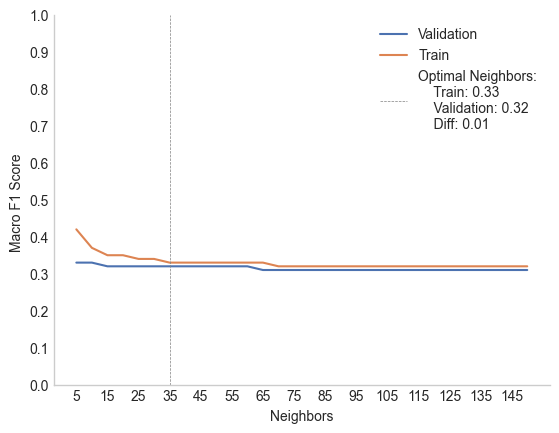

In [57]:
estimate_knn_df = get_results(estimate_knn, {"model__n_neighbors": "neighbors"})

train_score_35 = estimate_knn_df.loc[
    estimate_knn_df["neighbors"] == 35, "mean_train_score"
].values[0]
test_score_35 = estimate_knn_df.loc[
    estimate_knn_df["neighbors"] == 35, "mean_test_score"
].values[0]
score_difference = abs(train_score_35 - test_score_35)


sns.lineplot(
    x="neighbors",
    y="mean_test_score",
    data=estimate_knn_df,
    label="Validation",
)
sns.lineplot(x="neighbors", y="mean_train_score", data=estimate_knn_df, label="Train")
plt.axvline(
    x=35,
    color="gray",
    linestyle="--",
    label=f"Optimal Neighbors:\n    Train: {train_score_35:.2f}\n    Validation: {test_score_35:.2f}\n    Diff: {score_difference:.2f}",
    linewidth=0.5,
)
plt.xticks(np.arange(5, 155, 10))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Macro F1 Score ")
plt.xlabel("Neighbors")
plt.legend()
plt.show()

In [59]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectPercentile

In [63]:
x_cleaned = pd.DataFrame(baseline.fit_transform(X))

x_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574026 entries, 0 to 574025
Data columns (total 25 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       574026 non-null  float64
 1   1       574026 non-null  float64
 2   2       574026 non-null  float64
 3   3       574026 non-null  float64
 4   4       574026 non-null  float64
 5   5       574026 non-null  float64
 6   6       574026 non-null  float64
 7   7       574026 non-null  float64
 8   8       574026 non-null  float64
 9   9       574026 non-null  float64
 10  10      574026 non-null  float64
 11  11      574026 non-null  float64
 12  12      574026 non-null  float64
 13  13      574026 non-null  float64
 14  14      574026 non-null  float64
 15  15      574026 non-null  float64
 16  16      574026 non-null  float64
 17  17      574026 non-null  float64
 18  18      574026 non-null  float64
 19  19      574026 non-null  float64
 20  20      574026 non-null  float64
 21  21      57

In [20]:
# a = SelectKBest(score_func=mutual_info_classif(x_cleaned, y, n_neighbors=35), k=10)

In [62]:
def custom_mutual_info_classif(X, y):
    return mutual_info_classif(X, y, n_neighbors=35)


pipeline = Pipeline(
    [
        ("preprocessing", None),
        (
            "feature_selection",
            SelectPercentile(score_func=custom_mutual_info_classif, percentile=None),
        ),
        ("model", None),
    ]
)


param_grid = [
    # Logistic Regression
    {
        "model": [LogisticRegression(max_iter=1000)],
        "preprocessing": [baseline],
        "feature_selection__percentile": [50, 90, 70],
    },
    # Decision Tree
    {
        "model": [DecisionTreeClassifier(max_depth=10)],
        "preprocessing": [baseline],  # , treatment_1],
        "feature_selection__k": [50, 90, 70],
    },
]


# Run GridSearchCV


gs = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=2,
    verbose=1,
    return_train_score=True,
)


gs.fit(X, y)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


KeyboardInterrupt: 

In [24]:
a = get_results(gs)
a

,model,preprocessing,mean_fit_time,std_fit_time,mean_train_score,std_train_score,mean_test_score,std_test_score,params
0,LogisticRegression,baseline,56.46,0.82,0.25,0.00,0.25,0.01,"{'feature_selection__k': 5, 'model': LogisticRegression(max_iter=1000), 'preprocessing': (ColumnTransformer(n_jobs=-1, transformers=[('num_pipeline', Pipeline(steps=[('date_to_num', Date_Feature_Engineering(date_columns=['Accident ' 'Date', 'Assembly ' 'Date', 'C-2 ' 'Date', 'C-3 ' 'Date', 'First ' 'Hearing ' 'Date'])), ('imputation', SimpleImputer(strategy='median')), ('outlier_capping', OutlierCapper())]), ['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'IME-... 'WCIO Nature of Injury Description', 'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code', 'OIICS Nature of Injury Description']), ('bin_pipeline', Pipeline(steps=[('convert_to_binary', BinaryFeatureTransformer()), ('impute', SimpleImputer(strategy='most_frequent'))]), ['Alternative Dispute Resolution', 'Attorney/Representative', 'COVID-19 Indicator', 'Gender'])]), FeatureUnion(transformer_list=[('scaler', StandardScaler())]))}"
1,LogisticRegression,baseline,54.48,0.04,0.30,0.01,0.29,0.01,"{'feature_selection__k': 10, 'model': LogisticRegression(max_iter=1000), 'preprocessing': (ColumnTransformer(n_jobs=-1, transformers=[('num_pipeline', Pipeline(steps=[('date_to_num', Date_Feature_Engineering(date_columns=['Accident ' 'Date', 'Assembly ' 'Date', 'C-2 ' 'Date', 'C-3 ' 'Date', 'First ' 'Hearing ' 'Date'])), ('imputation', SimpleImputer(strategy='median')), ('outlier_capping', OutlierCapper())]), ['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'IME-... 'WCIO Nature of Injury Description', 'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code', 'OIICS Nature of Injury Description']), ('bin_pipeline', Pipeline(steps=[('convert_to_binary', BinaryFeatureTransformer()), ('impute', SimpleImputer(strategy='most_frequent'))]), ['Alternative Dispute Resolution', 'Attorney/Representative', 'COVID-19 Indicator', 'Gender'])]), FeatureUnion(transformer_list=[('scaler', StandardScaler())]))}"
2,DecisionTreeClassifier,baseline,50.67,0.02,0.32,0.01,0.30,0.01,"{'feature_selection__k': 5, 'model': DecisionTreeClassifier(max_depth=10), 'preprocessing': (ColumnTransformer(n_jobs=-1, transformers=[('num_pipeline', Pipeline(steps=[('date_to_num', Date_Feature_Engineering(date_columns=['Accident ' 'Date', 'Assembly ' 'Date', 'C-2 ' 'Date', 'C-3 ' 'Date', 'First ' 'Hearing ' 'Date'])), ('imputation', SimpleImputer(strategy='median')), ('outlier_capping', OutlierCapper())]), ['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'IME-... 'WCIO Nature of Injury Description', 'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code', 'OIICS Nature of Injury Description']), ('bin_pipeline', Pipeline(steps=[('convert_to_binary', BinaryFeatureTransformer()), ('impute', SimpleImputer(strategy='most_frequent'))]), ['Alternative Dispute Resolution', 'Attorney/Representative', 'COVID-19 Indicator', 'Gender'])]), FeatureUnion(transformer_list=[('scaler', StandardScaler())]))}"
3,DecisionTreeClassifier,baseline,57.05,0.49,0.37,0.01,0.34,0.00,"{'feature_selection__k': 10, 'model': DecisionTreeClassifier(max_depth=10), 'preprocessing': (ColumnTransformer(n_jobs=-1, transformers=[('num_pipeline', Pipeline(steps=[('date_to_num', Date_Feature_Engineering(date_columns=['Accident ' 'Date', 'Assembly ' 'Date', 'C-2 ' 'Date', 'C-3 ' 'Date', 'First ' 'Hearing ' 'Date'])), ('imputation', SimpleImputer(strategy='median')), ('outlier_capping', OutlierCapper())]), ['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'IME-... 'WCIO Nature of Injury Description', 'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code', 'OIICS Nature of Injury Description']), ('bin_pipeline', Pipeline(steps=[('convert_to_binary', BinaryFeatureTransformer()), ('impute', SimpleImputer(strategy='most_frequent'))]), ['Alternative Dispute Resolution', 'Attorney/Representative', 'COVID-19 Indi

In [ ]:
def custom_mutual_info_classif(X, y):
    return mutual_info_classif(X, y, n_neighbors=35)


pipeline = Pipeline(
    [
        ("preprocessing", None),
        (
            "feature_selection",
            SelectKBest(score_func=custom_mutual_info_classif, k=10),
        ),
        ("model", None),
    ]

)



param_grid = [
    # Logistic Regression
    {

        "model": [LogisticRegression(max_iter=1000)],
        "preprocessing": [baseline],  # , treatment_1],
    },
    # Decision Tree
    {

        "model": [DecisionTreeClassifier(max_depth=10)],
        "preprocessing": [baseline],  # , treatment_1],
    },

    # # K-Nearest Neighbors
    # {
    #     "model": [KNeighborsClassifier(n_neighbors=5)],
    #     "preprocessing": [baseline],  # , treatment_1],
    # },
    # # Gaussian Naive Bayes
    # {
    #     "model": [GaussianNB()],
    #     "preprocessing": [baseline],  # , treatment_1],
    # },
    # # MLP Classifier
    # {

    #     "model": [MLPClassifier(max_iter=1000)],
    #     "preprocessing": [baseline],  # , treatment_1],
    # },
    # # Support Vector Classifier
    # {
    #     "model": [SVC(kernel="linear")],
    #     "preprocessing": [baseline],  # , treatment_1],
    # },
]



# Run GridSearchCV


gs = GridSearchCV(
    pipeline,

    param_grid=param_grid,
    scoring="f1_macro",
    cv=3,
    verbose=1,
    return_train_score=True,
)


gs.fit(X, y)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


In [45]:
results_df = get_results(gs, {"feature_selection__k": "Number of features"})
results_df

,model,preprocessing,mean_fit_time,std_fit_time,mean_train_score,std_train_score,mean_test_score,std_test_score,Number of features
0,LogisticRegression,baseline,56.46,0.82,0.25,0.00,0.25,0.01,5
1,LogisticRegression,baseline,54.48,0.04,0.30,0.01,0.29,0.01,10
2,DecisionTreeClassifier,baseline,50.67,0.02,0.32,0.01,0.30,0.01,5
3,DecisionTreeClassifier,baseline,57.05,0.49,0.37,0.01,0.34,0.00,10


In [22]:
dump(gs, "baseline.joblib")

['baseline.joblib']

# TRASH

In [40]:
X_test = baseline.fit_transform(X)

model = MLPClassifier(
    hidden_layer_sizes=(30, 20, 10), learning_rate_init=0.01, max_iter=1000
)
model.fit(X_test, y)

c:\Users\Diogo\OneDrive - NOVAIMS\IMS - Data Science\MDS\.studyenv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier(hidden_layer_sizes=(30, 20, 10), learning_rate_init=0.01,
              max_iter=1000)

In [55]:
X_background = shap.sample(X_test, 10)
explainer = shap.KernelExplainer(model.predict_proba, X_background)

In [56]:
explainer.shap_values(X_test, gc_collect=True)

  0%|          | 0/574025 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Working Version with placeholder FS

In [ ]:
# pipeline = Pipeline(
#     [
#         ("preprocessing", None),
#         ("feature_selection", SelectFromModel(LogisticRegression(max_iter=1000))),
#         ("model", None),
#     ]
# )

# param_grid = [
#     {
#         "model": [LogisticRegression(max_iter=1000)],
#         "model__C": [0.1, 1],
#         "model__solver": ["lbfgs"],
#         "preprocessing": [base, treatment_1],
#     },
#     {
#         "model": [DecisionTreeClassifier()],
#         "model__max_depth": [3, 5],
#         "model__criterion": ["gini"],
#         "preprocessing": [base, treatment_1],
#     },
# ]

# gs = GridSearchCV(
#     pipeline,
#     param_grid=param_grid,
#     scoring="f1_macro",
#     cv=2,
#     verbose=1,
#     return_train_score=True,
# )
# y = y.to_numpy().ravel()
# gs.fit(X, y)

# # dump(gs, "grid_search.joblib")

In [ ]:
def get_results(gs, round=2):
    results = {
        key: gs.cv_results_[key]
        for key in [
            "mean_fit_time",
            "std_fit_time",
            "mean_train_score",
            "std_train_score",
            "mean_test_score",
            "std_test_score",
            "params",
        ]
    }
    results_df = pd.DataFrame(
        {
            "model": [type(params["model"]).__name__ for params in results["params"]],
            "preprocessing": [
                getattr(params["preprocessing"], "name") for params in results["params"]
            ],
            **results,
        }
    )

    return results_df.round(round)

In [ ]:
get_results(gs)

In [ ]:
import seaborn as sns

sns.barplot(x="model", y="mean_test_score", hue="preprocessing", data=get_results(gs))

In [ ]:
# y_test_pred = gs.best_estimator_.predict(X_test)

In [ ]:
from sklearn.metrics import f1_score, classification_report
import time

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scores = {}
features = {}
classification_reports = {}
times = {}

for fold_num, (train_index, test_index) in enumerate(skf.split(X, y), start=1):
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    y_train = y_train.squeeze()
    begin = time.perf_counter()
    # Fit the pipeline
    pipefinal.fit(X_train, y_train)
    end = time.perf_counter()
    # Predict and calculate F1 score
    y_pred_train = pipefinal.predict(X_train)
    y_pred_val = pipefinal.predict(X_val)
    score_train = f1_score(y_train, y_pred_train, average="macro")
    score_val = f1_score(y_val, y_pred_val, average="macro")
    scores[fold_num] = [score_train, score_val]

    # Save classification reports
    report_train = classification_report(y_train, y_pred_train, output_dict=True)
    report_val = classification_report(y_val, y_pred_val, output_dict=True)
    classification_reports[fold_num] = {
        "train": report_train,
        "val": report_val,
    }

    # Extract selected features from RFECV
    selected_features = X.columns[pipefinal.named_steps["feature_selection"].support_]
    features[fold_num] = list(selected_features)
    times[fold_num] = end - begin
# Print results
for fold in scores.keys():
    print(
        f"Fold {fold}: F1 score (train, val) = {scores[fold]}, Selected features = {features[fold]}"
    )
    print(f"Classification report for fold {fold} (train):")
    print(classification_reports[fold]["train"])
    print(f"Classification report for fold {fold} (validation):")
    print(classification_reports[fold]["val"])
    print(f"Time for fold {fold}: {times[fold]}")

In [ ]:
pipefinal.fit(X_train, y_train_encoded)

In [ ]:
pipefinal.score(X_train, y_train_encoded)

In [ ]:
y_val_encoded = label_encoder.fit_transform(y_val)

In [ ]:
pipefinal.score(X_val, y_val_encoded)

In [ ]:
test_df = pd.read_csv("./resources/test_data.csv")
test_df.set_index("Claim Identifier", inplace=True)

In [ ]:
# Treating binary variables

# Convert Attorney/Representative to binary representation
test_df["Alternative Dispute Resolution"] = test_df[
    "Alternative Dispute Resolution"
].map({"Y": 1, "N": 0, "U": np.nan})

# Convert Attorney/Representative to binary representation
test_df["Attorney/Representative"] = test_df["Attorney/Representative"].map(
    {"Y": 1, "N": 0}
)

# Convert COVID-19 Indicator to binary representation
test_df["COVID-19 Indicator"] = test_df["COVID-19 Indicator"].map({"Y": 1, "N": 0})

# Create a binary variable for the male gender
test_df["Male"] = np.select(
    [
        test_df["Gender"] == "M",
        test_df["Gender"] == "F",
        test_df["Gender"] == "X",
        test_df["Gender"] == "U",
    ],
    [1, 0, 0, 0],
)

In [ ]:
test_df["Accident Date"] = pd.to_datetime(test_df["Accident Date"])
test_df["Assembly Date"] = pd.to_datetime(test_df["Assembly Date"])
test_df["C-2 Date"] = pd.to_datetime(test_df["C-2 Date"])
test_df["First Hearing Date"] = pd.to_datetime(test_df["First Hearing Date"])

test_df["Accident to Assembly Days"] = (
    test_df["Assembly Date"] - test_df["Accident Date"]
).dt.days
test_df["Accident to First Hearing Days"] = (
    test_df["First Hearing Date"] - test_df["Accident Date"]
).dt.days
test_df["Accident to C-2 Days"] = (
    test_df["C-2 Date"] - test_df["Accident Date"]
).dt.days

In [ ]:
# I. Burn or Scald - Heat or Cold Exposures - Contact With
burn_or_scald = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "11", "14", "84"]

# II. Caught In, Under or Between
caught_in_under_between = ["10", "12", "13", "20"]

# III. Cut, Puncture, Scrape Injured By
cut_puncture_scrape = ["15", "16", "17", "18", "19"]

# IV. Fall, Slip or Trip Injury
fall_slip_trip = ["25", "26", "27", "28", "29", "30", "31", "32", "33"]

# V. Motor Vehicle
motor_vehicle = ["40", "41", "45", "46", "47", "48", "50"]

# VI. Strain or Injury By
strain_or_injury = ["52", "53", "54", "55", "56", "57", "58", "59", "60", "61", "97"]

# VII. Striking Against or Stepping On
striking_against = ["65", "66", "67", "68", "69", "70"]

# VIII. Struck or Injured By
struck_or_injured = ["74", "75", "76", "77", "78", "79", "80", "81", "85", "86"]

# IX. Rubbed or Abraded By
rubbed_or_abraded = ["94", "95"]

# X. Miscellaneous Causes
miscellaneous = ["82", "83", "87", "88", "89", "90", "91", "93", "96", "98", "99"]


test_df["WCIO Cause of Injury Code SUPRA"] = test_df["WCIO Cause of Injury Code"].apply(
    lambda code: (
        "I. Burn or Scald - Heat or Cold Exposures - Contact With"
        if str(code).split(".")[0] in burn_or_scald
        else (
            "II. Caught In, Under or Between"
            if str(code).split(".")[0] in caught_in_under_between
            else (
                "III. Cut, Puncture, Scrape Injured By"
                if str(code).split(".")[0] in cut_puncture_scrape
                else (
                    "IV. Fall, Slip or Trip Injury"
                    if str(code).split(".")[0] in fall_slip_trip
                    else (
                        "V. Motor Vehicle"
                        if str(code).split(".")[0] in motor_vehicle
                        else (
                            "VI. Strain or Injury By"
                            if str(code).split(".")[0] in strain_or_injury
                            else (
                                "VII. Striking Against or Stepping On"
                                if str(code).split(".")[0] in striking_against
                                else (
                                    "VIII. Struck or Injured By"
                                    if str(code).split(".")[0] in struck_or_injured
                                    else (
                                        "IX. Rubbed or Abraded By"
                                        if str(code).split(".")[0] in rubbed_or_abraded
                                        else (
                                            "X. Miscellaneous Causes"
                                            if str(code).split(".")[0] in miscellaneous
                                            else np.nan
                                        )
                                    )
                                )
                            )
                        )
                    )
                )
            )
        )
    )
)

In [ ]:
# Specific Injury codes (Category I)
specific_injury = [
    "1",
    "2",
    "3",
    "4",
    "7",
    "10",
    "13",
    "16",
    "19",
    "22",
    "25",
    "28",
    "30",
    "31",
    "32",
    "34",
    "36",
    "37",
    "38",
    "40",
    "41",
    "42",
    "43",
    "46",
    "47",
    "49",
    "52",
    "53",
    "54",
    "55",
    "58",
    "59",
]

# Occupational Disease or Cumulative Injury codes (Category II)
occupational_disease = [
    "60",
    "61",
    "62",
    "63",
    "64",
    "65",
    "66",
    "67",
    "68",
    "69",
    "70",
    "71",
    "72",
    "73",
    "74",
    "75",
    "76",
    "77",
    "78",
    "79",
    "80",
    "83",
]

# Multiple Injuries codes (Category III)
multiple_injuries = ["90", "91"]


test_df["WCIO Nature of Injury Code SUPRA"] = test_df[
    "WCIO Nature of Injury Code"
].apply(
    lambda code: (
        "Category I: Specific Injury"
        if str(code).split(".")[0] in specific_injury
        else (
            "Category II: Occupational Disease or Cumulative Injury"
            if str(code).split(".")[0] in occupational_disease
            else (
                "Category III: Multiple Injuries"
                if str(code).split(".")[0] in multiple_injuries
                else np.nan
            )
        )
    )
)

In [ ]:
# I. Head
head = [
    "10",
    "11",
    "12",
    "13",
    "13A",
    "13B",
    "13C",
    "14",
    "14A",
    "14B",
    "14C",
    "15",
    "16",
    "17",
    "18",
    "19",
]

# II. Neck
neck = ["20", "21", "22", "23", "24", "25", "26"]

# III. Upper Extremities
upper_extremities = [
    "30",
    "31",
    "32",
    "33",
    "34",
    "35",
    "36",
    "36A",
    "36B",
    "36C",
    "36D",
    "36E",
    "36F",
    "36G",
    "36H",
    "36I",
    "36J",
    "36K",
    "36L",
    "36M",
    "36N",
    "36O",
    "36P",
    "37",
    "37A",
    "37B",
    "37C",
    "38",
    "39",
]

# IV. Trunk
trunk = [
    "40",
    "41",
    "42",
    "43",
    "44",
    "45",
    "46",
    "47",
    "48",
    "49",
    "60",
    "61",
    "62",
    "63",
]

# V. Lower Extremities
lower_extremities = [
    "50",
    "51",
    "52",
    "53",
    "54",
    "55",
    "56",
    "57",
    "57A",
    "57B",
    "57C",
    "57D",
    "57E",
    "57F",
    "57G",
    "58",
    "58A",
    "58B",
    "58C",
]

# VI. Multiple Body Parts
multiple_body_parts = ["64", "65", "66", "90", "91", "99"]


test_df["WCIO Part Of Body Code SUPRA"] = test_df["WCIO Part Of Body Code"].apply(
    lambda code: (
        "I. Head"
        if str(code).split(".")[0] in head
        else (
            "II. Neck"
            if str(code).split(".")[0] in neck
            else (
                "III. Upper Extremities"
                if str(code).split(".")[0] in upper_extremities
                else (
                    "IV. Trunk"
                    if str(code).split(".")[0] in trunk
                    else (
                        "V. Lower Extremities"
                        if str(code).split(".")[0] in lower_extremities
                        else (
                            "VI. Multiple Body Parts"
                            if str(code).split(".")[0] in multiple_body_parts
                            else np.nan
                        )
                    )
                )
            )
        )
    )
)

In [ ]:
predictions_test1 = pipefinal.predict(test_df)

In [ ]:
predictions_test2 = label_encoder.inverse_transform(predictions_test1)

In [ ]:
predictions = pd.DataFrame(test_df.index)
predictions["Claim Injury Type"] = predictions_test2
predictions.to_csv("predictions_pipeline.csv", index=False)